# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [58]:
df = pd.read_csv('bikes_rent.csv')


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

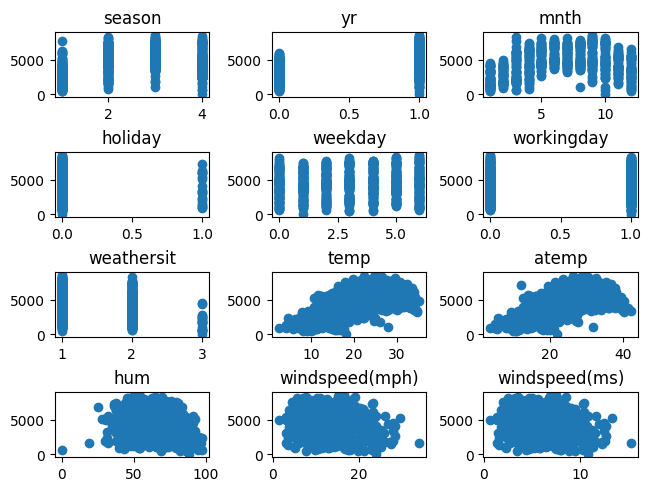

In [33]:
fig, ax = plt.subplots(4,3, constrained_layout = True)

c = 0
for i in range(4):
    for j in range(3):
        ax[i,j].scatter(df.iloc[:,c], df['cnt'])
        ax[i,j].set_title(df.columns[c])
        c+=1

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця? 
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно. 

1. Нелінійний 2. temp, atemp

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [30]:
df.iloc[:,:-2].corrwith(df['cnt'], axis = 0)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [36]:
df.loc[:,['temp','atemp','hum','windspeed(mph)','windspeed(ms)']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms)
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [37]:
df.loc[:,['temp','atemp','hum','windspeed(mph)','windspeed(ms)']].mean()

temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [39]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [228]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]


array([[ 1.354375  ,  0.99863295,  1.58866019, ...,  0.74372737,
        -0.21121111, -0.21121111],
       [-1.34821315, -1.00136893, -1.31026791, ..., -1.33538868,
         1.12681211,  1.12681211],
       [ 1.354375  , -1.00136893,  1.00887457, ..., -0.29551449,
         0.50349108,  0.50349108],
       ...,
       [ 1.354375  , -1.00136893,  0.71898176, ...,  1.55169951,
        -0.5404777 , -0.5404777 ],
       [-1.34821315,  0.99863295, -1.0203751 , ..., -1.06046036,
         0.41449871,  0.41449871],
       [-0.44735043, -1.00136893, -0.73048229, ...,  1.34385394,
         0.77643372,  0.77643372]])

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [41]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression().fit(X,y)
print(regressor.coef_)

[ 5.70867008e+02  1.02196655e+03 -1.41303064e+02 -8.67566998e+01
  1.37223795e+02  5.63919291e+01 -3.30229171e+02  3.67482366e+02
  5.85547376e+02 -1.45610449e+02  1.24545782e+13 -1.24545782e+13]


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [47]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

regressor = LinearRegression().fit(X,y)
for f, w in zip(df.columns, regressor.coef_):
    print(f"Feature {f}: weight {w}")

Feature season: weight 570.8670076611145
Feature yr: weight 1021.9665469400028
Feature mnth: weight -141.3030637030831
Feature holiday: weight -86.75669979530014
Feature weekday: weight 137.22379464035518
Feature workingday: weight 56.39192911323907
Feature weathersit: weight -330.22917063423307
Feature temp: weight 367.4823659599251
Feature atemp: weight 585.5473755227584
Feature hum: weight -145.61044903827423
Feature windspeed(mph): weight 12454578205026.746
Feature windspeed(ms): weight -12454578205225.209


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [51]:

lasso_regressor = Lasso(alpha=1.0).fit(X,y)
for f, w in zip(df.columns, lasso_regressor.coef_):
    print(f"Feature {f}: weight {w}")

Feature season: weight 560.2416160308865
Feature yr: weight 1019.4634940657195
Feature mnth: weight -128.73062703678704
Feature holiday: weight -86.15278133371096
Feature weekday: weight 137.34789390496334
Feature workingday: weight 55.21237064135661
Feature weathersit: weight -332.3698569623486
Feature temp: weight 376.36323620969756
Feature atemp: weight 576.530793504552
Feature hum: weight -144.129155003486
Feature windspeed(mph): weight -197.13968940248475
Feature windspeed(ms): weight -2.805092921827712e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [50]:
Ridge_regressor = Ridge(alpha=1.0).fit(X,y)
for f, w in zip(df.columns, Ridge_regressor.coef_):
    print(f"Feature {f}: weight {w}")

Feature season: weight 563.0645722520151
Feature yr: weight 1018.9483787875287
Feature mnth: weight -131.87332028247516
Feature holiday: weight -86.74609799709226
Feature weekday: weight 138.00511117871935
Feature workingday: weight 55.90311037506447
Feature weathersit: weight -332.3497884990726
Feature temp: weight 386.4578891918964
Feature atemp: weight 566.34704706008
Feature hum: weight -145.07132729867305
Feature windspeed(mph): weight -99.2594410817849
Feature windspeed(ms): weight -99.25944115434763


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [78]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    Ridge_regressor = Ridge(alpha = alpha).fit(X,y)
    coefs_ridge.append(Ridge_regressor.coef_)
    Lasso_regressor = Lasso(alpha = alpha).fit(X,y)
    coefs_lasso.append(Lasso_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)



Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

10
10
10
10
10
10
10
10
10
10
10
10


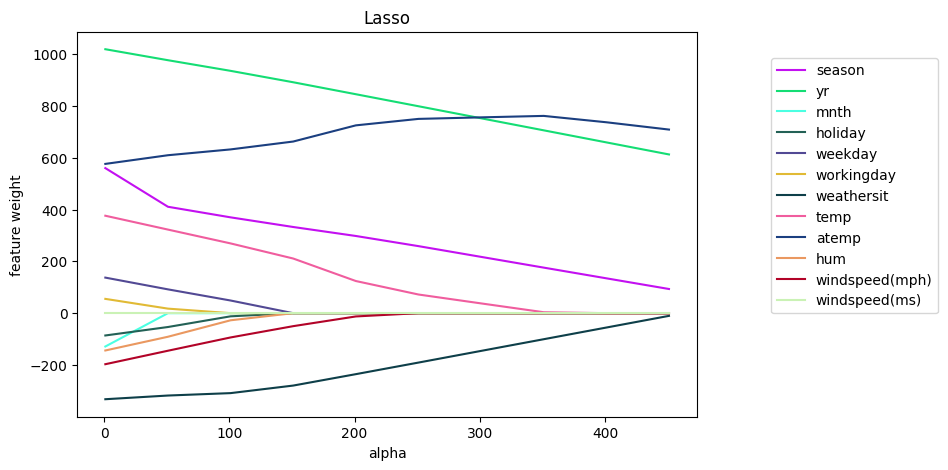

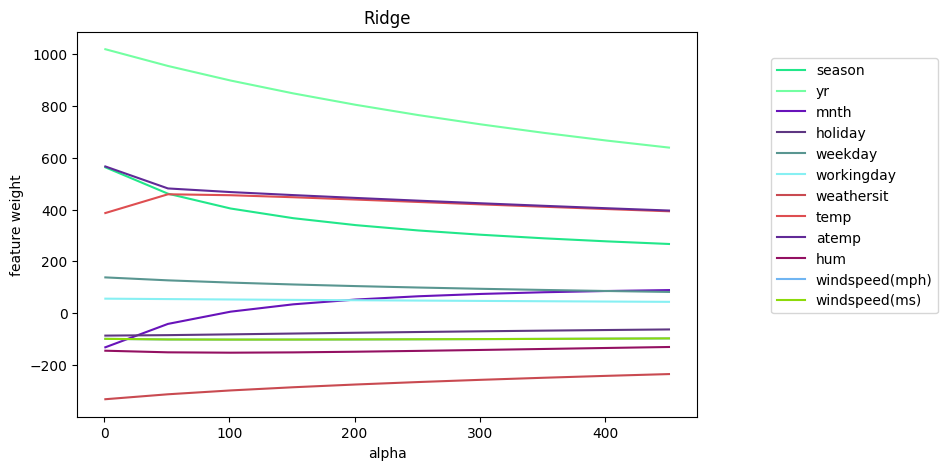

In [79]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    print(len(coef))
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha? 
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

1. L1
2. Ваги можуть наблизитись до нуля, що зробить їх в контексті моделі незначними. У Lasso ми помножуємо наш коефіцієнт регуляризації на модуль суми вагів, а в Ridge на суму квадратів. 
3. Lasso виключає ознаку. У випадку з Ridge ознака буде наближуватися до 0, але не виключить її тобто не занулить
4. Lasso

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [183]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = data.iloc[:,0]
    y = data.iloc[:,1]
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [159]:
b = np.array([[1, 2]])
a = np.array([[4, 5, 6],
             [4, 5, 6]])
print(b.T)
np.concatenate((b.T, a), axis=1)

[[1]
 [2]]


array([[1, 4, 5, 6],
       [2, 4, 5, 6]])

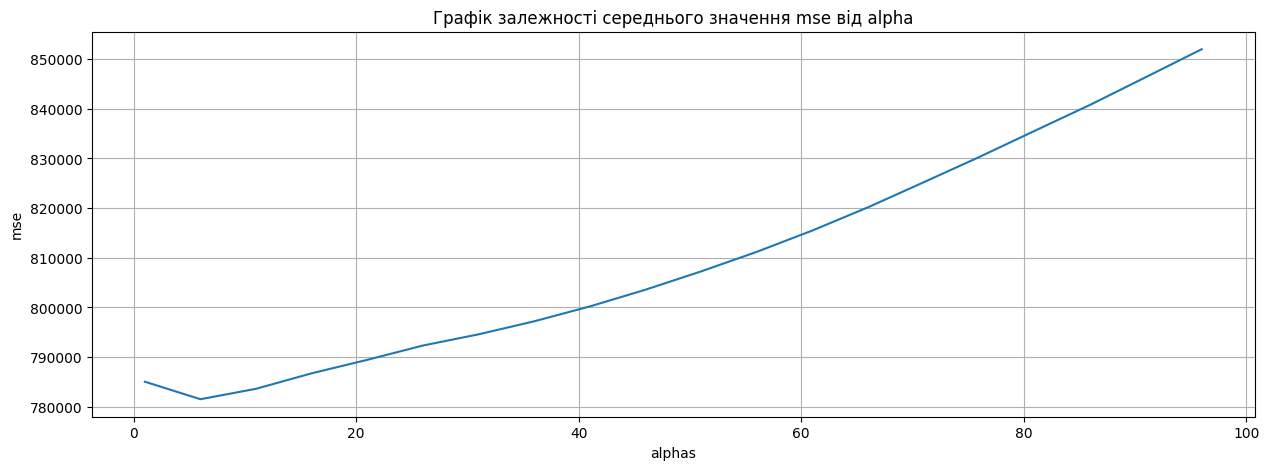

In [214]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(cv = 3, alphas=alphas).fit(X, y)

data = np.concatenate((regressor.alphas_.reshape((20,1)),regressor.mse_path_), axis=1)

df_lasso = pd.DataFrame(data, columns=["alpha", "k-1","k-2", "k-3"])
df_lasso["mean"] = df_lasso.iloc[:,1:].mean(axis=1)

create_plot(df_lasso.loc[:,['alpha', 'mean']], "Графік залежності середнього значення mse від alpha" , "alphas", "mse")


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


alpha that minimize MSE [6.]


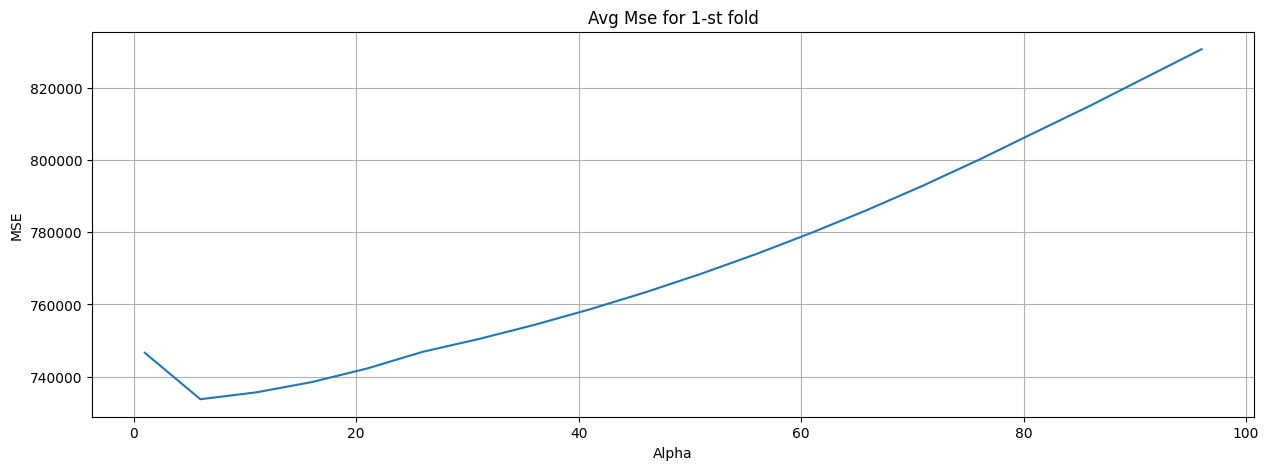

alpha that minimize MSE [1.]


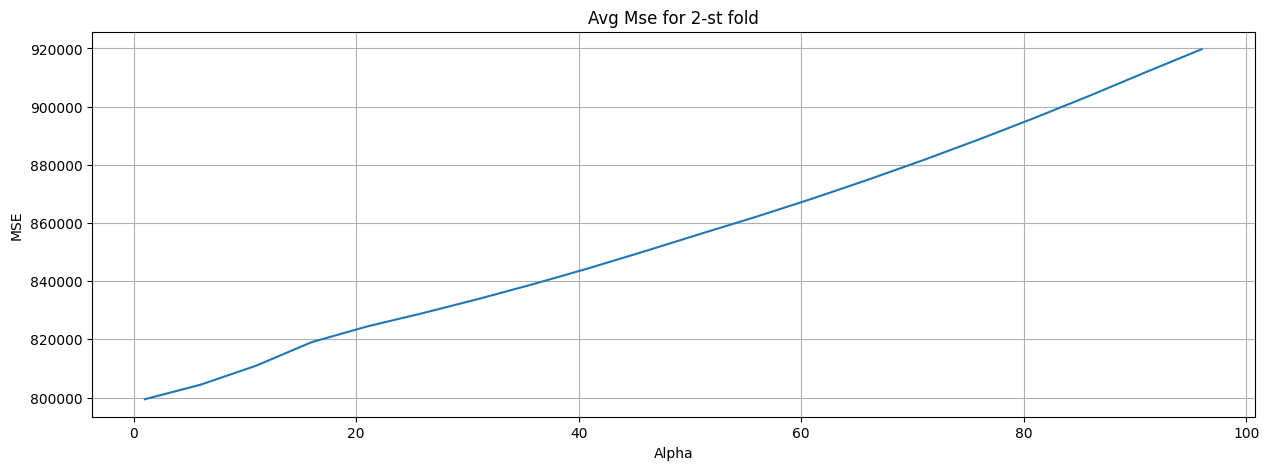

alpha that minimize MSE [51.]


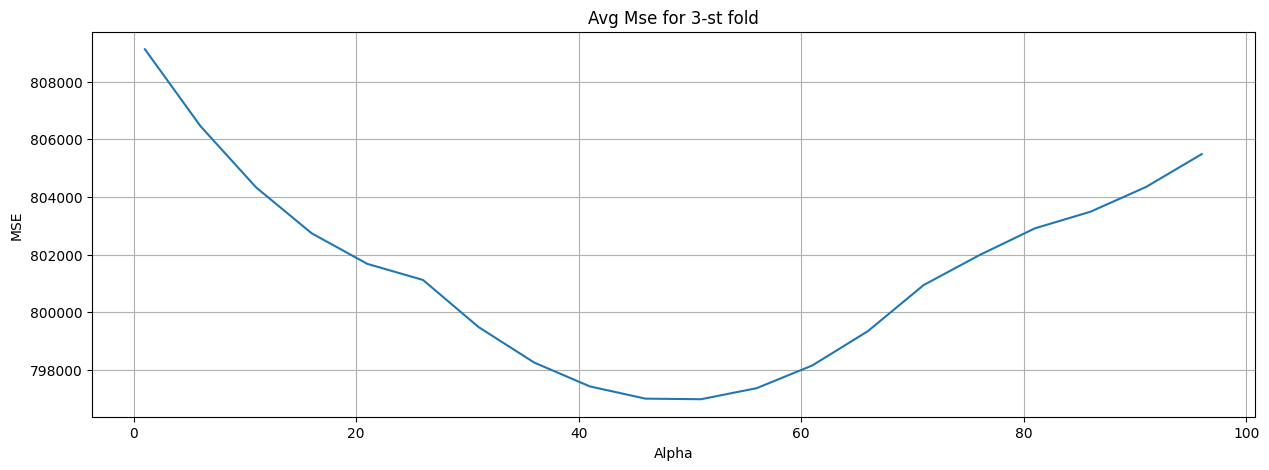

In [222]:

for i in range(1,4):
    target_alpha = df_lasso[df_lasso.iloc[:,i] == min (df_lasso.iloc[:,i])]['alpha'].values
    print(f"alpha that minimize MSE {target_alpha}")
    create_plot(df_lasso.iloc[:, [0, i]],f"Avg Mse for {i}-st fold","Alpha","MSE")
  


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [249]:
model_coefs = {}
for f, w in zip(df.columns, regressor.coef_):
    model_coefs [f] = w
model_coefs_sorted = {k: v for k, v in sorted(model_coefs.items(), key=lambda item: item[1])}
features_positive = {k: model_coefs_sorted[k] for k in list(model_coefs_sorted)[-4:]}
model_coefs

{'season': np.float64(532.0189828413537),
 'yr': np.float64(1015.0602226430597),
 'mnth': np.float64(-100.03952614356669),
 'holiday': np.float64(-83.29395987529924),
 'weekday': np.float64(132.50446549095804),
 'workingday': np.float64(51.55708561407371),
 'weathersit': np.float64(-330.5598567399815),
 'temp': np.float64(370.67985503003325),
 'atemp': np.float64(581.3969310654985),
 'hum': np.float64(-140.00740550068878),
 'windspeed(mph)': np.float64(-191.7714084713497),
 'windspeed(ms)': np.float64(-2.685559936767258e-08)}

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [245]:
features_negative = {k: model_coefs_sorted[k] for k in list(model_coefs_sorted)[:3]}
features_negative 

{'weathersit': np.float64(-330.5598567399815),
 'windspeed(mph)': np.float64(-191.7714084713497),
 'hum': np.float64(-140.00740550068878)}

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [248]:
null_features = {}
for key, val in model_coefs.items():
    if val < 1e-3 and val > -1e-3:
        null_features[key] = val

null_features

{'windspeed(ms)': np.float64(-2.685559936767258e-08)}

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.